
# Custom Naive Bayes Classifier

In [1]:
## Importing the Libraries
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.downloader import download as nltk_download
nltk_download('stopwords')
nltk_download('punkt')
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings("ignore")
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daviddada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daviddada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Peeking at the data

# remove unimportant cols for nice displaying
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Data Exploration 
Count plot of the output categories: positive and negative

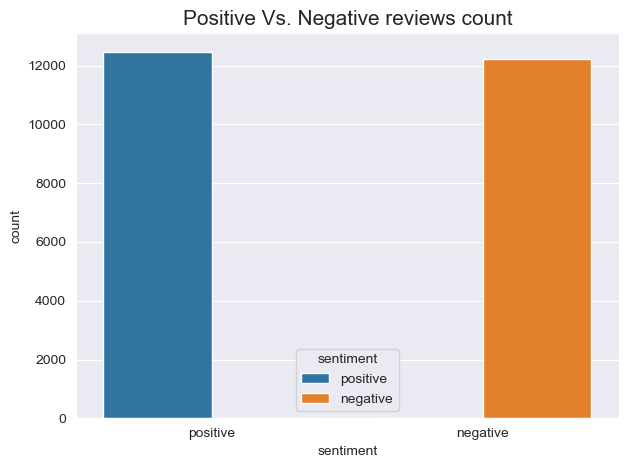

In [4]:
plt.figure(figsize = (7,5))
sns.countplot(x='sentiment', hue='sentiment', data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class:
It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

In [5]:
# positive    12474
# negative    12225

df_majority = df.loc[df['sentiment'] == 'positive']
df_minority = df.loc[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
## Checking the shape of data Just to ensure that upsampling was done successfully.
upsampled_shape = df_upsampled.shape

# print the shape of data set with the help of shape function having "negative" as class label
print(negative_upsample.shape)

(12474, 2)


In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data
counts = df_upsampled['sentiment'].value_counts()

# print the shape of data set with the help of shape function having "positive" as class label
print(df.loc[df['sentiment'] == 'positive'].shape)

(12474, 2)


# Dataset Splitting

In [8]:
# Dataset Training and Test split 

## Considering 10000 positive and 10000 negative data points
positive_data_points_train = df_upsampled.loc[df['sentiment'] == 'positive'].iloc[:10000]
negative_data_points_train = df_upsampled.loc[df['sentiment'] == 'negative'].iloc[:10000]

## Considering the remaining data points for test
positive_data_points_test = df_upsampled.loc[df['sentiment'] == 'positive'].iloc[10000:]
negative_data_points_test = df_upsampled.loc[df['sentiment'] == 'negative'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])

In [9]:
## Total number of classes and their count
print(y_train.value_counts())

sentiment
positive    10000
negative    10000
Name: count, dtype: int64


In [10]:
print(y_test.value_counts())

sentiment
positive    2474
negative    2474
Name: count, dtype: int64


## Pre-processing the Reviews:

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced.  
  
### Summary
* Removal of stopwords, punctuation
* Removal of filler words
* Text Normalization
* Stemming
* HTML Sanitation

In [11]:
# stemmer
stemmer = PorterStemmer()

### Clean review function based on rules mentioned above

In [12]:
def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review.
    '''

    cleaned_review = review

    # remove links
    cleaned_review = re.sub(r"<br />", "", cleaned_review)

    # punctuation
    cleaned_review = re.sub(f"[{string.punctuation}]", "", cleaned_review)

    # lowercase
    cleaned_review = cleaned_review.lower()

    # tokenize
    cleaned_review = word_tokenize(cleaned_review)

    # stopwords
    cleaned_review = [word for word in cleaned_review if word not in stopwords.words('english')]

    # stemming
    cleaned_review = [stemmer.stem(token) for token in cleaned_review]

    # recombine tokens
    cleaned_review = " ".join(cleaned_review)

    return cleaned_review

### Find Occurrence Helper Function:

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [13]:
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word

        { (word,label):num_occurrence }
    Return:
        n: the number of times the word with its corresponding label appears.
    '''

    n = frequency[(word, label)] if (word,label) in frequency else 0

    return n

# print(find_occurrence({ ('hello', 0) : 10 },'hello', 0))

### Converting Categorical Data to Numerical Format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format.

In [14]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [15]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

sentiment
0    10000
1    10000
Name: count, dtype: int64

In [16]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'The Sunshine Boys is one of my favorite feel good movies. I first saw it when it as the Christmas attraction at Radio City Music Hall when it first came out and loved it ever since. I ended up seeing it 6 times in the theaters, and if it was playing today I\'d go out to see it again.<br /><br />Now a lot of the reviews here mentioned the wonderful performances of the leads. Matthau was brilliant, but had the misfortune of being nominated against Jack Nicholson\'s Oscar winning performance of Randall P. MacMurphy in "One Flew Over the Cuckoo\'s nest. Burns did win, though Richard Benjiman deserved at least to be nominated as well. Even the smallest roles were played to perfection, like Fritz Feld auditioning for the potato chips commercial. <br /><br />Which brings me to my reason for reviewing this film, the direction of the greatly underrated Herbert Ross. Ross who previously brought a two person play, "The Owl And The Pussycat" to the screen and made a full movie out of it, does it 

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [17]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

sunshin boy one favorit feel good movi first saw christma attract radio citi music hall first came love ever sinc end see 6 time theater play today id go see againnow lot review mention wonder perform lead matthau brilliant misfortun nomin jack nicholson oscar win perform randal p macmurphi one flew cuckoo nest burn win though richard benjiman deserv least nomin well even smallest role play perfect like fritz feld audit potato chip commerci bring reason review film direct greatli underr herbert ross ross previous brought two person play owl pussycat screen made full movi open play without make look like photograph stage play fleashen stori charactersher 20 minut film get scene open play ben clark come see uncl tell comedi special though dialogu play first twenti minut sequenc total new year ago see broadway reviv play jack klugman toni randal wonder think ross screenwrit playwright simon improv wonder film


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Implementation

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [18]:
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        key = (word, label)
        output_occurrence[key] = output_occurrence[key] + 1 if key in output_occurrence else 1
    return output_occurrence

### Testing with example reviews:

In [19]:
# Testing the function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

### Frequency Dictionary:
 Frequency dictionary of words is another tool we will use to understand how certain words are associated with negative reviews, and positive

In [20]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [21]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequency of occurrence of word given that a review is 'negative'.
freqs

{('sunshin', 0): 27,
 ('boy', 0): 912,
 ('one', 0): 10731,
 ('favorit', 0): 865,
 ('feel', 0): 2255,
 ('good', 0): 5910,
 ('movi', 0): 17222,
 ('first', 0): 3476,
 ('saw', 0): 1368,
 ('christma', 0): 146,
 ('attract', 0): 298,
 ('radio', 0): 208,
 ('citi', 0): 640,
 ('music', 0): 2093,
 ('hall', 0): 143,
 ('came', 0): 738,
 ('love', 0): 4803,
 ('ever', 0): 2111,
 ('sinc', 0): 1171,
 ('end', 0): 3573,
 ('see', 0): 5803,
 ('6', 0): 118,
 ('time', 0): 6162,
 ('theater', 0): 390,
 ('play', 0): 3986,
 ('today', 0): 730,
 ('id', 0): 440,
 ('go', 0): 3249,
 ('againnow', 0): 1,
 ('lot', 0): 1980,
 ('review', 0): 698,
 ('mention', 0): 501,
 ('wonder', 0): 1797,
 ('perform', 0): 2726,
 ('lead', 0): 1115,
 ('matthau', 0): 91,
 ('brilliant', 0): 710,
 ('misfortun', 0): 15,
 ('nomin', 0): 245,
 ('jack', 0): 421,
 ('nicholson', 0): 48,
 ('oscar', 0): 440,
 ('win', 0): 396,
 ('randal', 0): 30,
 ('p', 0): 22,
 ('macmurphi', 0): 1,
 ('flew', 0): 24,
 ('cuckoo', 0): 16,
 ('nest', 0): 27,
 ('burn', 0): 1

## Training the Naive Bayes Model:

Calculating the log likelihood and log prior values, as these are important for testing.

Word frequency count using the above functions is used to compute the log likelihood.

We will need the logprior and loglikelihood output by the model from this function. 

In [33]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels corresponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''

    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([word for word, label in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (equals zero)
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:
            # Increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents
    pos_num_docs = (train_y == 1).sum() + 1

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = (train_y == 0).sum() + 1

    # Calculate logprior
    logp = { 1: np.log(pos_num_docs/num_doc), 0: np.log(neg_num_docs/num_doc) }
    # scalar log prior since binary class
    logprior = np.log(pos_num_docs/neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = (freqs[(word, 1)] if (word, 1) in freqs else 0) + 1
        freq_neg = (freqs[(word, 0)] if (word, 0) in freqs else 0) + 1
        freq_total = freq_pos + freq_neg

        # calculate the probability that each word is positive, and negative
        p_w_pos = freq_pos/freq_total
        p_w_neg = freq_neg/freq_total

        # calculate the log likelihood of the word
        loglikelihood[word] = [np.log(p_w_pos), np.log(p_w_neg)]

    return logprior, loglikelihood

In [34]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

{1: -0.693047185559612, 0: -0.693047185559612} 0.0 10001 10001
0.0
88799


### Expected Output 

0.0 <br>
91425

## Implementing Naive Bayes Predict Function:

In [24]:
def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = clean_review(review).split()

    # probability for each word
    # word_p = {word: 0 for word in word_l}

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = logprior
    prob_pos = logprior
    prob_neg = logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            # total_prob += None
            prob_pos += loglikelihood[word][0]
            prob_neg += loglikelihood[word][1]

            # save the log likelihood
            # word_p[word] = loglikelihood[word]

    # print(word_p)
    return 0 if prob_pos < prob_neg else 1

## Testing a sample review

In [25]:
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The output is', p)

The output is 1


### Expected Output :
The expected output is 1

## Implementing Naive Bayes Test function:

In [26]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(1)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.abs(np.array(y_hats) - np.array(test_y)))

    correct = 0
    for i in range(len(test_y)):
        if test_y[i] == y_hats[i]:
            correct += 1

    accuracy = correct/len(test_y)

    return accuracy

In [27]:
for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [28]:
# other testing
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Evaluation: Accuracy
Using a confusion matrix

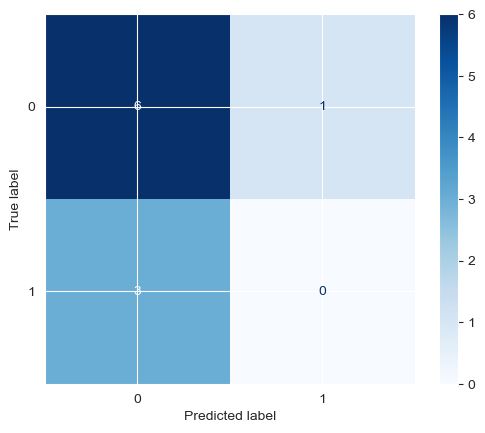

0.6


In [29]:
'''
Input:
seed: Random seed

Output: accuracy
'''
def evalAccuracy(seed):
    N_samples = 10

    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['review'], df['sentiment'], train_size=N_samples, test_size=N_samples, random_state=seed)

    # map to numerical data
    output_map = {'positive': 0, 'negative': 1}
    y_train_a = y_train_a.map(output_map)
    y_test_a = y_test_a.map(output_map)

    freqs_a = review_counter({}, X_train_a, y_train_a)
    logprior, loglikelihood = train_naive_bayes(freqs_a, X_train_a, y_train_a)

    y_hat_a = X_test_a.map(lambda x : naive_bayes_predict(x, logprior, loglikelihood))

    # list for easy indexing
    y_test_a = y_test_a.tolist()
    y_hat_a = y_hat_a.tolist()

    # print confusion matrix
    cm = confusion_matrix(y_test_a, y_hat_a)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp = disp.plot(cmap=plt.get_cmap("Blues"))
    plt.show()

    # accuracy
    correct = 0
    for i in range(len(y_test_a)):
        if y_test_a[i] == y_hat_a[i]:
            correct += 1

    accuracy = correct/len(y_test_a)

    return accuracy

print(evalAccuracy(10))

# Saving The Model
Saving the model parameters is crucial for future deployments

In [30]:
model_parameters = {
    'logprior': logprior,
    'loglikelihood': loglikelihood
}

# Save the model parameters to a file
with open('movie_sentiment_model_parameters.json', 'w') as file:
    json.dump(model_parameters, file)